# Training Trainers
### Authors: Nigel Nelson and Collin Quinn - 2/15/22
---

## Research Questions:
- What features are most predictive of injuries in long distance runners
- Can a injury prediction model be made accurate enough to provide meaningful insight on training protocols

## Hypothesis: 
- The greater the perceived exertion an athlete reports, the higher the probability that later training sessions result in injury.

## The Dataset:
- The data set consists of a detailed training log from a Dutch high-level running team over a period of seven years (2012-2019). Included are the middle and long distance runners of the team, that is, those competing on distances between the 800 meters and the marathon. This design decision is motivated by the fact that these groups have strong endurance based components in their training, making their training regimes comparable. 
- The data set contains 42,766 entries from 74 runners, of whom 27 are women and 47 are men. 583 injuries were recorded, which means that about 98% of the data set's entries were non-injuries.  
    - Each entry in the data set corresponds to a single athlete and a week of their training which is comprised of 10 features recorded for 7 days leading up to a potential injury. 
    - The 10 daily features are: Number of training sessions, total distance ran, distance ran at low heart rate intensity, distance ran at medium heart rate intensity, distance ran at high heart rate intensity, number of strength training sessions, hours of alternative training (such as cycling or swimming), percieved exertion (how exhausted the athlete at completion of training), percieved training success (how well the athlete felt training went that day), perceived recovery (how recovered the athlete felt before beginning training), and a lastly an injury flag that indicates whether the 7 days of training recorded resulted in in injury that prevented the athlete from completing a training session.
    

- Source: https://dataverse.nl/dataset.xhtml?persistentId=doi:10.34894/UWU9PV


### Imports:

In [230]:
import sys

sys.path
sys.executable

'C:\\Users\\quinnc\\Anaconda3\\python.exe'

In [231]:
%pip install --user pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter


Note: you may need to restart the kernel to use updated packages.


In [232]:
pd.__version__

'1.3.5'

---
## Data Preprocessing:


#### Loading the Data Set:
- Discrete features are loaded as categorical features
- Running intensity features are converted to more readable column names for greater interpretability
- Non-useful columns are dropped, such as Date and Athlete ID
- Note: There were not any empty values in the data set

In [233]:
print(pd)
day_data = pd.read_csv("dataverse_files\day_approach_maskedID_timeseries.csv",
dtype={'nr. sessions': 'category',
'nr. sessions.1': 'category',
'nr. sessions.2': 'category',
'nr. sessions.3': 'category',
'nr. sessions.4': 'category',
'nr. sessions.5': 'category',
'nr. sessions.6': 'category',
'strength training': 'category',
'strength training.1': 'category',
'strength training.2': 'category',
'strength training.3': 'category',
'strength training.4': 'category',
'strength training.5': 'category',
'strength training.6': 'category',
'injury': 'category'})
day_data = day_data.drop(columns=['Date', 'Athlete ID'])

day_data.head()

for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    km_Z3 = 'km Z3-4' + suffix
    km_Z5 = 'km Z5-T1-T2' + suffix
    km_sprinting = 'km sprinting' + suffix
    low_inten = 'km low-intensity' + suffix
    med_inten = 'km medium-intensity' + suffix
    hgih_inten = 'km high-intensity' + suffix

    day_data.rename(columns = {km_Z3: low_inten,
                            km_Z5: med_inten,
                            km_sprinting: hgih_inten},
                            inplace = True)

<module 'pandas' from 'C:\\Users\\quinnc\\Anaconda3\\lib\\site-packages\\pandas\\__init__.py'>


In [234]:
day_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   nr. sessions                 42766 non-null  category
 1   total km                     42766 non-null  float64 
 2   km low-intensity             42766 non-null  float64 
 3   km medium-intensity          42766 non-null  float64 
 4   km high-intensity            42766 non-null  float64 
 5   strength training            42766 non-null  category
 6   hours alternative            42766 non-null  float64 
 7   perceived exertion           42766 non-null  float64 
 8   perceived trainingSuccess    42766 non-null  float64 
 9   perceived recovery           42766 non-null  float64 
 10  nr. sessions.1               42766 non-null  category
 11  total km.1                   42766 non-null  float64 
 12  km low-intensity.1           42766 non-null  float64 
 13  k

---
## Data Analysis and Visualization:
- Each of the features are analyzed using statistical test in order to determine which features have the greatest statistical significance. Continous features are evaluated using the Kruskal Wallis test, while the categorical features are evaluated using chi square contingency test.

In [235]:
pvalues = {}

continuous_features = ['total km', 'km low-intensity', 'km medium-intensity', 'km high-intensity', 'hours alternative',
'perceived exertion', 'perceived trainingSuccess', 'perceived recovery']

categorical_features = ['nr. sessions', 'strength training']

for feature in continuous_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        samples_by_group = []
        for value in set(day_data["injury"]):
            mask = day_data["injury"] == value
            samples_by_group.append(day_data[col][mask])
        stat, p = stats.kruskal(*samples_by_group)
        pvalues[col] = p

for feature in categorical_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        combination_counts = day_data.value_counts(subset=["injury", col]).unstack(level=0).fillna(0)
        chi2, p, _, _ = stats.chi2_contingency(combination_counts)
        pvalues[col] = p

### Plotting feature P-values:
- P-values are plotted from least to greatest. In order to control the familywise error rate, a Bonferroni Corrrection is applied to an initial alpha of 0.01 to get a final alpha value of ~0.000143.

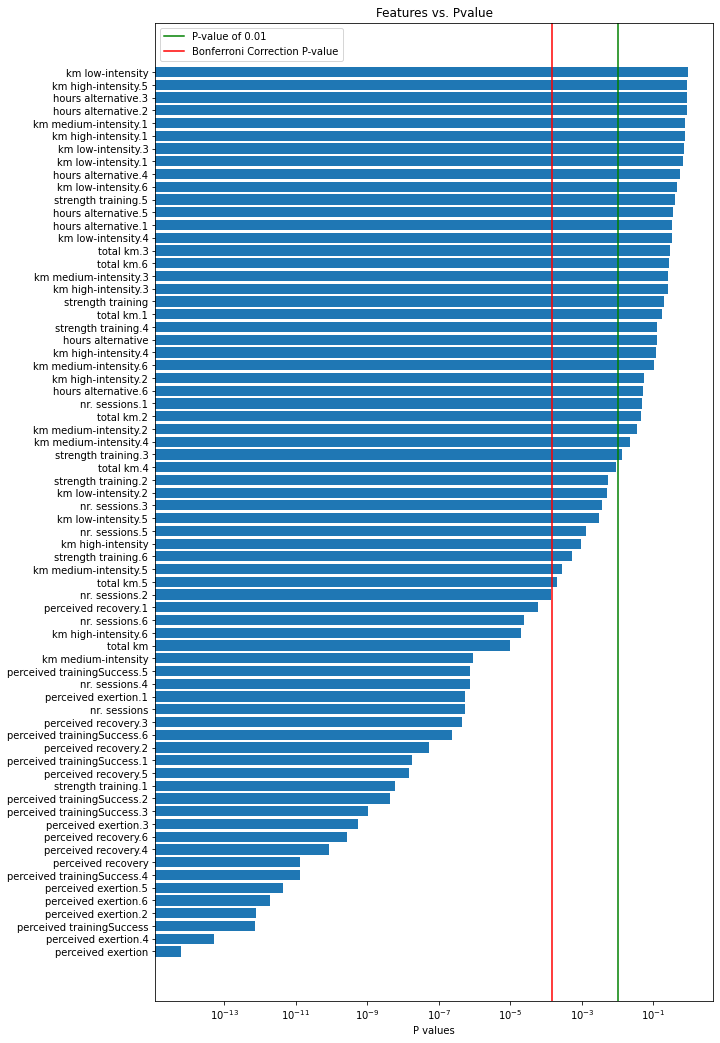

In [236]:
pvalues = dict(sorted(pvalues.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots()

features = pvalues.keys()
y_pos = np.arange(len(features))

ax.barh(y_pos, pvalues.values(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()
ax.set_xlabel('P values')
ax.set_title('Features vs. Pvalue')
ax.set_xscale('log')
fig.set_size_inches(10, 18)

plt.axvline(x=0.01, c='g', label="P-value of 0.01")
plt.axvline(x=0.01/70, c='r', label="Bonferroni Correction P-value")
plt.legend()

### Applying Bonferroni Correction
- The Bonferroni correction method was chosen to control the familywise error rate.

In [237]:
stat_sig_features = []
for feat, pvalue in pvalues.items():
    if pvalue < .01/70:
        stat_sig_features.append(feat)


sig_features = day_data[stat_sig_features]



---
### Plotting the most predictive features:

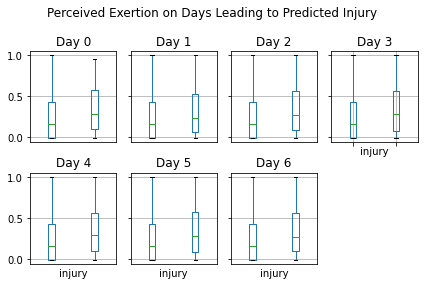

In [238]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived exertion" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('Perceived Exertion on Days Leading to Predicted Injury')
plt.tight_layout()

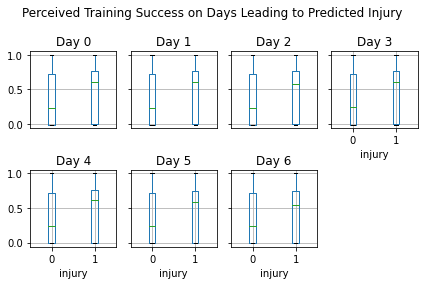

In [239]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived trainingSuccess" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Perceived Training Success on Days Leading to Predicted Injury')
plt.tight_layout()

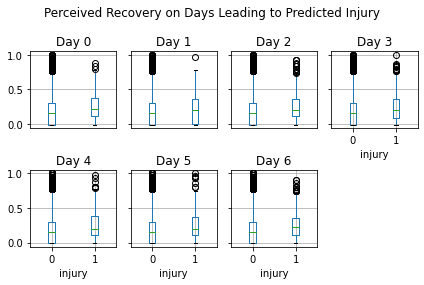

In [240]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived recovery" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Perceived Recovery on Days Leading to Predicted Injury')
plt.tight_layout()

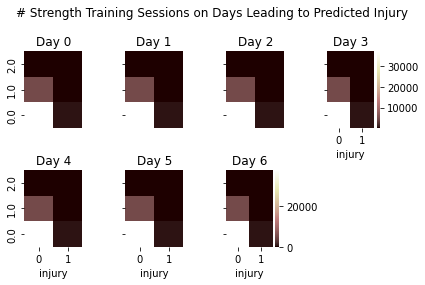

In [241]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "strength training" + suffix
    injury_strength_count = day_data[[col, 'injury']].groupby(
    [col, 'injury']).size().unstack(-1).fillna(0)
    if i in [3, 6]:
        sns.heatmap(injury_strength_count, cmap='pink', ax=ax.flatten()[i])
    else:
        sns.heatmap(injury_strength_count, cmap='pink', ax=ax.flatten()[i], cbar=False)
    ax.flatten()[i].title.set_text(f'Day {i}')
    ax.flatten()[i].set_ylabel("")
    ax.flatten()[i].invert_yaxis()
    i += 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('# Strength Training Sessions on Days Leading to Predicted Injury')
plt.tight_layout()

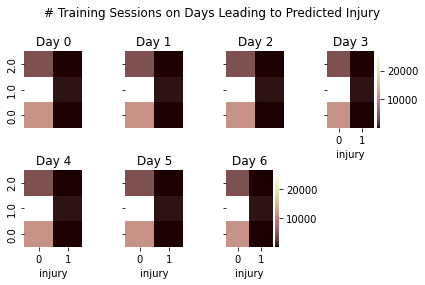

In [242]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "nr. sessions" + suffix
    injury_session_count = day_data[[col, 'injury']].groupby(
    [col, 'injury']).size().unstack(-1).fillna(0)
    if i in [3, 6]:
        sns.heatmap(injury_session_count, cmap='pink', ax=ax.flatten()[i])
    else:
        sns.heatmap(injury_session_count, cmap='pink', ax=ax.flatten()[i], cbar=False)
    ax.flatten()[i].title.set_text(f'Day {i}')
    ax.flatten()[i].set_ylabel("")
    ax.flatten()[i].invert_yaxis()
    i += 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('# Training Sessions on Days Leading to Predicted Injury')
plt.tight_layout()

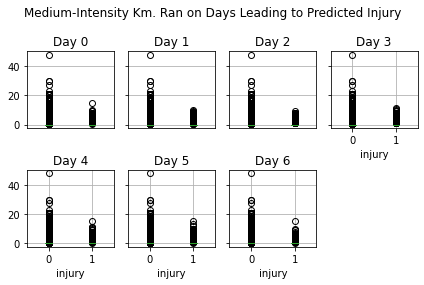

In [243]:

fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "km medium-intensity" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Medium-Intensity Km. Ran on Days Leading to Predicted Injury')
plt.tight_layout()


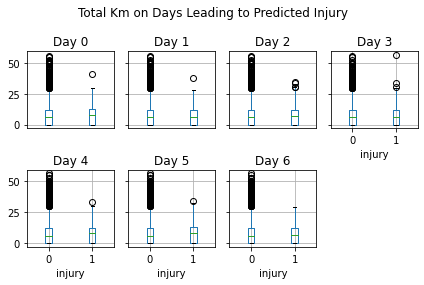

In [244]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "total km" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Total Km on Days Leading to Predicted Injury')
plt.tight_layout()


---
### Using SVD to plot the two most predictive Components:

In [245]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sig_features)

In [246]:
svd = TruncatedSVD(n_components=10, random_state=17)
svd_matrix = svd.fit_transform(scaled_features)
svd_matrix.shape

(42766, 10)

Text(0.5, 1.0, '% data explained vs. Component Index #')

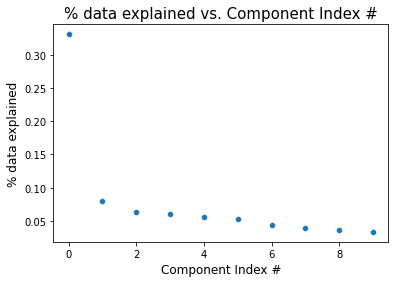

In [247]:
sns.scatterplot(x=range(0,10), y=svd.explained_variance_ratio_)
plt.ylabel('% data explained', fontsize=12)
plt.xlabel('Component Index #', fontsize=12)
plt.title('% data explained vs. Component Index #', fontsize=15)

Text(0.5, 1.0, '2nd vs. 1st Highest Explained Variance Components')

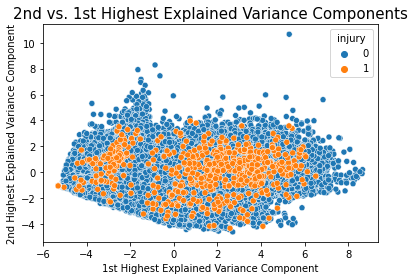

In [248]:
sns.scatterplot(x=svd_matrix[:,0], y=svd_matrix[:,1], hue=day_data['injury'])
plt.ylabel('2nd Highest Explained Variance Component', fontsize=10)
plt.xlabel('1st Highest Explained Variance Component', fontsize=10)
plt.title('2nd vs. 1st Highest Explained Variance Components', fontsize=15)

---
## Data Modeling and Prediction

In this part, we are first utilizng a random forest classification model. In the first part (unbalanced models), we are randomly sampling from the data set. It is important to keep in mind that 98% of the data set's entries were non-injuries. In part 2, we are using a balanced model, where we have an equal amount of injuries and non-injuries.

---
### Part 1: **Unbalanced** Models:

#### Train/Test Split for All features (unbalanced training data set)

In [249]:
df_train, df_test = train_test_split(day_data, stratify=day_data["injury"], random_state=42)
y_train = df_train["injury"]
y_test = df_test["injury"]
X_train = df_train.drop(columns='injury')
X_test = df_test.drop(columns='injury')

### Train a Random Forest Classifier with ALL features

F1 Score:  0.49656276485544776
Top 3 predictive features...
perceived exertion.2
perceived recovery.5
perceived recovery.2


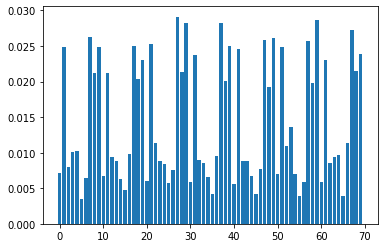

In [250]:
nums = {}
pred_feat_names = []
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_

y_pred_rf2=model.predict(X_test)
from sklearn.metrics import f1_score

f1_score = f1_score(y_test, y_pred_rf2, average='macro')

print("F1 Score: ", f1_score)

# summarize feature importance
for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    nums[i] = v

print('Top 3 predictive features...')

for x in range(0,3):
    max_key = max(nums, key=nums.get)
    colname = day_data.columns[max_key]
    pred_feat_names.append(colname)
    print(colname)
    del nums[max_key]


# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Plot the top 2 most predictive features

C:\Users\quinnc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


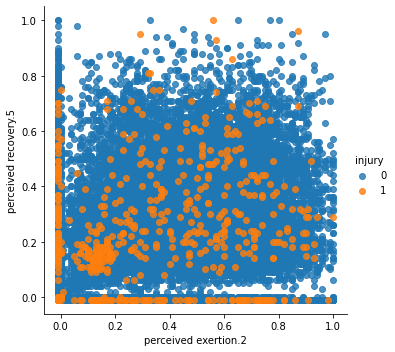

In [251]:
sns.lmplot(pred_feat_names[0], pred_feat_names[1], data=day_data, hue='injury',fit_reg=False)
plt.show()

From the plot above, it can be assessed that it would be difficult to obtain a linear separation from class 0 vs. class 1.

### Training Random Forest Classifier with feature selection

In this part, we are using feature selection with a random forest classifier, where we take the top 3 most predictive features to create a new model. 

In [252]:
day_data_new = day_data[[pred_feat_names[0], pred_feat_names[1], pred_feat_names[2], 'injury']].copy()
df_train_fs, df_test_fs = train_test_split(day_data_new, stratify=day_data_new["injury"], random_state=42)
y_train_fs = df_train_fs["injury"]
y_test_fs = df_test_fs["injury"]
X_train_fs = df_train_fs.drop(columns='injury')
X_test_fs = df_test_fs.drop(columns='injury')


F1 Score:  0.4961832061068703
Top 3 predictive features...
perceived recovery.2
perceived exertion.2
perceived recovery.5


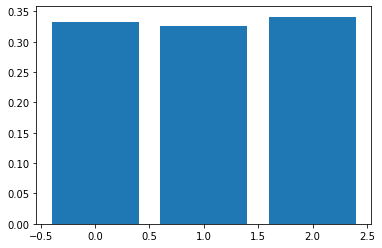

In [253]:
nums = {}
model_fs = RandomForestClassifier()
from sklearn.metrics import f1_score

model_fs.fit(X_train_fs, y_train_fs)
# get importance
importance_fs = model_fs.feature_importances_

y_pred_rf2=model_fs.predict(X_test_fs)

f1_score = f1_score(y_test_fs, y_pred_rf2, average='macro')

print("F1 Score: ", f1_score)

# summarize feature importance
for i,v in enumerate(importance_fs):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    nums[i] = v
    
    
print('Top 3 predictive features...')

for x in range(0,3):
    max_key = max(nums, key=nums.get)
    colname = day_data_new.columns[max_key]
    print(colname)
    del nums[max_key]


# plot feature importance
pyplot.bar([x for x in range(len(importance_fs))], importance_fs)
pyplot.show()

Plot the top two most predictive features. 

C:\Users\quinnc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


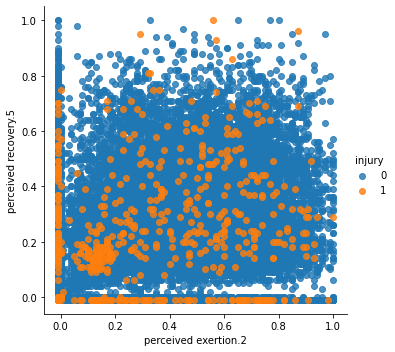

In [254]:
sns.lmplot(pred_feat_names[0], pred_feat_names[1], data=day_data, hue='injury',fit_reg=False)
plt.show()

From the plot above, it can be assessed that it would be difficult to obtain a linear separation from class 0 vs. class 1.

**Part 1 Analysis:** From the unbalanced models, it can be assessed that our unbalanced data set is causing our model with all features, along with our model with feature selection to give us essentially identical F1 score values. This is not desired, and is almost certainly because 

---
### Part 2: **Balanced** Models:

In [255]:
# all_injuries = y_train.astype('int32') == 1
# indexes = []
# for idx, val in enumerate(all_injuries):
#     indexes.append(val or idx <= 2000)
# temp_X_train = X_train[indexes]
# temp_y_train = y_train[indexes]
# categorical_features = ['nr.sessions', 'strength training']
# for feature in categorical_features:
#     for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
#         col = feature + suffix
#         temp_X_train[col] = temp_X_train[col].astype('float64').astype('int64')


# print('Original dataset shape %s' % Counter(temp_y_train))
# sm = SMOTE(random_state=42)
# X_sm, y_sm = sm.fit_resample(temp_X_train, temp_y_train)
# print('Resampled dataset shape %s' % Counter(y_sm))
# for feature in categorical_features:
#     for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
#         col = feature + suffix
#         X_sm[col] = X_sm[col].astype('category')

In [256]:
X = day_data.drop(columns=['injury'])
y = day_data['injury']

In [257]:
# SMOTE: https://www.kaggle.com/ktattan/recall-97-with-smote-random-forest-tsne

categorical_features = ['nr. sessions', 'strength training']
for feature in categorical_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        X[col] = X[col].astype('float64').astype('int64')
smote=SMOTE(random_state=42)

X_sm , y_sm = smote.fit_resample(X,y)
print('Value Counts for labels:\n', y_sm.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state=42)


scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Value Counts for labels:
 0    42183
1    42183
Name: injury, dtype: int64


F1 Score:  0.9912741773064846
Top 3 predictive features...
perceived trainingSuccess.4
perceived trainingSuccess
perceived trainingSuccess.6


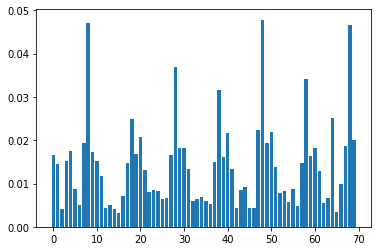

In [258]:
nums_bal = {}
pred_feat_names_bal = []
# define the model
model_bal = RandomForestClassifier()
# fit the model
model_bal.fit(scaled_X_train, y_train)

# get importance
importance_bal = model_bal.feature_importances_

y_pred_bal=model_bal.predict(scaled_X_test)

from sklearn.metrics import f1_score

f1_score = f1_score(y_test, y_pred_bal, average='macro')

print("F1 Score: ", f1_score)

# summarize feature importance
for i,v in enumerate(importance_bal):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    nums_bal[i] = v

print('Top 3 predictive features...')

for x in range(0,3):
    max_key = max(nums_bal, key=nums_bal.get)
    colname = day_data.columns[max_key]
    pred_feat_names_bal.append(colname)
    print(colname)
    del nums_bal[max_key]


# plot feature importance
pyplot.bar([x for x in range(len(importance_bal))], importance_bal)
pyplot.show()